In [1]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import json
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors

import h5py
from ipyfilechooser import FileChooser

from alvra_tools import *
from alvra_tools.channels import *
#from alvra_tools.channels_raw import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
def process_image(image2D, threshold_low, threshold_high):
    image2D_thr = image2D.copy()
    #image2D_thr = convert_to_photon_num_range(image2D_thr, [threshold_low,threshold_high])
    image2D_thr[image2D < threshold_low] = 0
    image2D_thr[image2D > threshold_high] = 0
    image2D_thr = convert_to_photon_num_range(image2D_thr, [threshold_low,threshold_high])
    return image2D_thr

def plot_tool(spectra_ON, spectra_OFF, roi, bin_):
    x_axis = np.arange(roi[0], roi[1])
    spectra_on_rebin  = bin_sum(spectra_ON,  bin_)
    spectra_off_rebin = bin_sum(spectra_OFF, bin_)
    x_axis_rebin = bin_mean(x_axis, bin_)
    return x_axis_rebin, spectra_on_rebin, spectra_off_rebin

## First load a few images to identify ROIs and check threshold

In [3]:
# data = SFDataFiles('/sf/alvra/data/p19506/raw/static_data/011_XES_ZnFoil_9800pink/run_000526*')
data = SFDataFiles('/sf/alvra/data/p19262/raw/static_data/RIXS_CpRhCO2_50fs_3001eV_CRY1unfocused/run_009291.JF02T09V02.h5')
nframes = 100
threshold_low = 2

# Choose a pedestal file (usually located in /sf/alvra/data/*pgroup*/res/JF_pedestals) 
# if you do not want to use the closest in time

# pedestal_file = "/sf/alvra/data/p17983/res/JF_pedestals/pedestal_20190727_2115.JF02T09V02.res.h5"
pedestal_file = None

##################################################################
clock = Clock()
total = 0
total_thr = 0
ch_JF = data['JF02T09V02']
images = ch_JF.data[:nframes]

print ('Loaded {} images'.format(images.shape[0]))

for i in range(nframes):
    single_image = images[i, :]
    image_thr = single_image.copy()
    image_thr[single_image < threshold_low] = 0
    total_thr += image_thr
    total += single_image
    #total /= nframes

print ("It took", clock.tick(), "seconds to process this file")

Auto-located gain file: /sf/jungfrau/config/gainMaps/JF02T09V02/gains.h5
Auto-located pedestal file: /sf/alvra/data/p19262/raw/JF_pedestals/run_007970.JF02T09V02.res.h5
jungfrau file: 12:27 03.12.2021
pedestal file: 10:31 02.12.2021
    mtime difference: 1 day, 1:56:32.733096
Loaded 100 images
It took 21.13 seconds to process this file


<IPython.core.display.Javascript object>


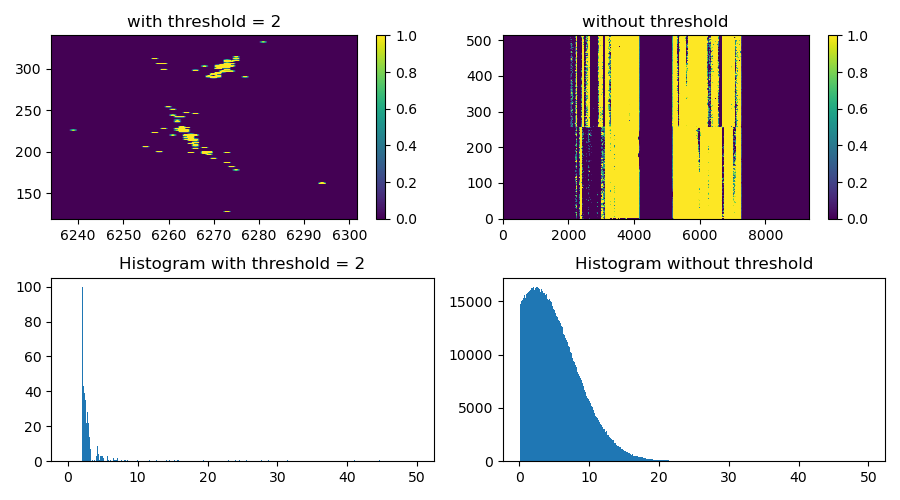

In [4]:
plt.figure(figsize=(9,5))
plt.subplots_adjust(wspace=0.5)
plt.subplot(221)
plt.imshow(total_thr, origin="lower", aspect='auto', vmin=0, vmax=1)
plt.title("with threshold = {}".format(threshold_low))
plt.colorbar()
plt.subplot(222)
plt.imshow(total, origin="lower", aspect='auto', vmin=0, vmax=1)
plt.title("without threshold")
plt.colorbar()
plt.subplot(224)
plt.title("Histogram without threshold")
plt.hist(total.ravel(), bins=np.arange(0.1,50,0.1))
plt.subplot(223)
plt.title("Histogram with threshold = {}".format(threshold_low))
plt.hist(total_thr.ravel(), bins=np.arange(0.1,50,0.1))
plt.tight_layout()
plt.show()

## Next cells for a single file, ONLY JF file!

In [15]:
DIR = '/sf/alvra/data/p19262/raw/static_data/XES_acac_jet_3007/'
run = 'run_003822'

In [16]:
roi1 = (2800, 3200, 180, 240) #signal CRY2 low
roi2 = (2800, 3200, 260, 320) #signal CRY2 up

roi3 = (6000, 6200, 200, 240) #signal CRY1 low
roi4 = (6000, 6200, 260, 320) #signal CRY1 up

threshold_low = 2
threshold_high = 10


######################################################################################
clock = Clock()
JF_single_file = DIR + run + '.JF02T09V02.h5'

spectrum_roi1 = 0
spectrum_roi2 = 0
spectrum_roi3 = 0
spectrum_roi4 = 0

print("Processing file %s" % (JF_single_file))
clear_output(wait=True)
nshots = None
images_roi1, images_roi2, images_roi3, images_roi4, pids = \
    load_crop_JF_batches(JF_single_file, roi1, roi2, roi3, roi4, nshots=nshots)

images_roi1_thr = images_roi1.copy()
images_roi1_thr[images_roi1 < threshold_low] = 0
images_roi1_thr[images_roi1 > threshold_high] = 0
images_roi1_thr = convert_to_photon_num_range(images_roi1_thr, [threshold_low,threshold_high])

images_roi2_thr = images_roi2.copy()
images_roi2_thr[images_roi2 < threshold_low] = 0
images_roi2_thr[images_roi2 > threshold_high] = 0
images_roi2_thr = convert_to_photon_num_range(images_roi2_thr, [threshold_low,threshold_high])

images_roi3_thr = images_roi3.copy()
images_roi3_thr[images_roi3 < threshold_low] = 0
images_roi3_thr[images_roi3 > threshold_high] = 0
images_roi3_thr = convert_to_photon_num_range(images_roi3_thr, [threshold_low,threshold_high])

images_roi4_thr = images_roi4.copy()
images_roi4_thr[images_roi4 < threshold_low] = 0
images_roi4_thr[images_roi4 > threshold_high] = 0
images_roi4_thr = convert_to_photon_num_range(images_roi4_thr, [threshold_low,threshold_high])

spectrum_roi1  += images_roi1_thr.sum(axis = 1).sum(axis = 0)
spectrum_roi2  += images_roi2_thr.sum(axis = 1).sum(axis = 0)
spectrum_roi3  += images_roi3_thr.sum(axis = 1).sum(axis = 0)
spectrum_roi4  += images_roi4_thr.sum(axis = 1).sum(axis = 0)

print ("It took", clock.tick(), "seconds to process this file")

#print ("It took", clock.tock(), "seconds to process {} files".format(len(patch)))

Auto-located gain file: /sf/jungfrau/config/gainMaps/JF02T09V02/gains.h5
Auto-located pedestal file: /sf/alvra/data/p19262/raw/JF_pedestals/run_003635.JF02T09V02.res.h5
jungfrau file: 16:42 30.11.2021
pedestal file: 13:45 30.11.2021
    mtime difference: 2:57:22.338150
Total images = 5001, load them in batches of 1000
Load batch = slice(0, 1000, None)
Load batch = slice(1000, 2000, None)
Load batch = slice(2000, 3000, None)
Load batch = slice(3000, 4000, None)
Load batch = slice(4000, 5000, None)
Load batch = slice(5000, 5001, None)
It took 18.33 seconds to process this file


<IPython.core.display.Javascript object>


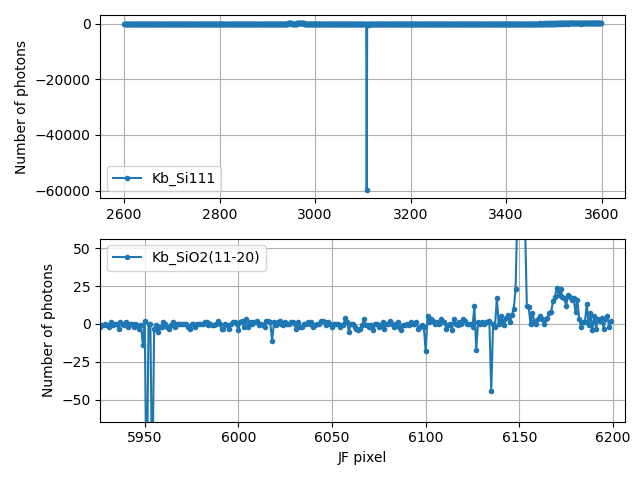

In [17]:
spectrum_bkg_roi1 = spectrum_roi1  - spectrum_roi2
err_spectrum_ro1 = np.sqrt(spectrum_roi1)
err_bkg_2 = np.sqrt(spectrum_roi2)

spectrum_bkg_roi3 = spectrum_roi3 - spectrum_roi4
err_spectrum_roi3 = np.sqrt(spectrum_roi3)
err_bkg_4 = np.sqrt(spectrum_roi4)


bin1_ = 1   # change the bin size if wanted, 1 is every pixel
bin3_ = 1

spectrum_bkg_1 = spectrum_bkg_roi1.copy()
spectrum_bkg_3 = spectrum_bkg_roi3.copy()
x_axis_1 = np.arange(roi1[0], roi1[1])
x_axis_3 = np.arange(roi3[0], roi3[1])


spectrum_rebin1  = bin_sum(spectrum_bkg_1,  bin1_)
x_axis_rebin1 = bin_mean(x_axis_1, bin1_)
spectrum_rebin3  = bin_sum(spectrum_bkg_3,  bin3_)
x_axis_rebin3 = bin_mean(x_axis_3, bin3_)


#low_err_Ka= (spectrum_rebin1)-np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
#high_err_Kb= (spectra_on_rebin1 - spectra_off_rebin1)+np.sqrt(spectra_on_err1**2+spectra_off_err1**2)

#spectrumAllOutFoc=spectra_on_rebin1 + spectra_off_rebin1
plt.figure()
#plt.suptitle("E = 3004 eV")
plt.subplot(211)
#plt.title(scan_name + ", delay = {} ps".format(str(np.round(Delay_ps_single,3))))
plt.plot(x_axis_rebin1, spectrum_rebin1, label="Kb_Si111", marker='.')
plt.ylabel('Number of photons')
plt.legend(loc="best")
plt.grid()

plt.subplot(212)
#plt.title(scan_name + ", delay = {} ps".format(str(np.round(Delay_ps_single,3))))
plt.plot(x_axis_rebin3, spectrum_rebin3, label="Kb_SiO2(11-20)", marker='.')
plt.ylabel('Number of photons')
plt.legend(loc="best")
plt.grid()
plt.xlabel("JF pixel")
plt.tight_layout()
plt.show()

#plt.savefig(savedir+'/XES_lines_examples_3004.png')

/sf/alvra/anaconda/alvra-analysis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


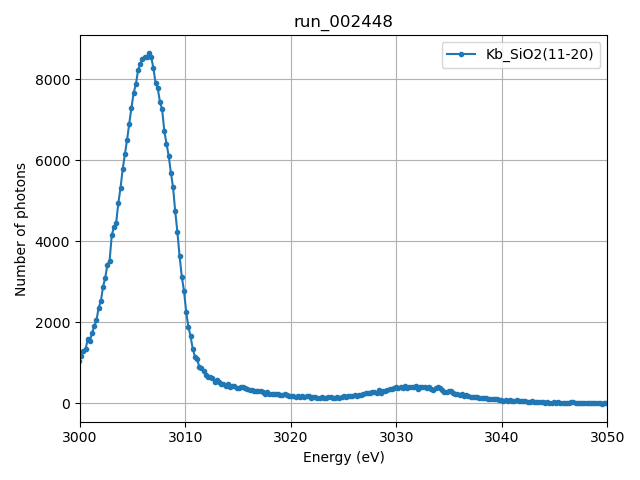

In [587]:
plt.figure()
plt.title(run)
plt.plot(xaxis3, spectrum_rebin3, label="Kb_SiO2(11-20)", marker='.')
plt.ylabel('Number of photons')
plt.legend(loc="best")
plt.grid()
plt.xlabel("Energy (eV)")
plt.xlim(3000, 3050)
#plt.ylim(0,50)
plt.tight_layout()
plt.show()

plt.savefig(savedir+'/XES_pink_Rh_2000shots.png')

In [479]:
zn100 = spectrum_rebin3.copy()

/sf/alvra/anaconda/alvra-analysis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/sf/alvra/anaconda/alvra-analysis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


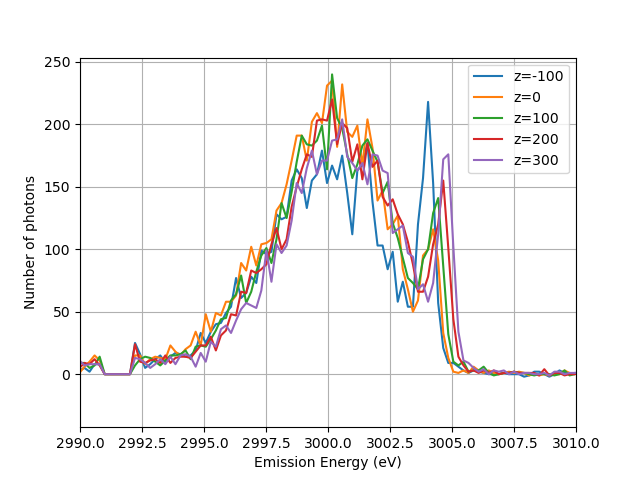

In [538]:
plt.figure()
plt.plot(xaxis3, zn100, label = 'z=-100')
plt.plot(xaxis3, z0, label = 'z=0')
plt.plot(xaxis3, z100, label = 'z=100')
plt.plot(xaxis3, z200, label = 'z=200')
plt.plot(xaxis3, z300, label = 'z=300')

#plt.axvline(3004, color = 'black')
plt.xlabel('Emission Energy (eV)')
plt.ylabel('Number of photons')

plt.grid()
plt.legend(loc='best')
plt.xlim(2990, 3010)
plt.show()

plt.savefig(savedir+'/z_change.png')

## Next cells for scans, ONLY JF file!

In [3]:
fc = FileChooser('/sf/alvra/data/p19262/raw/scan_info')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p19262/raw/scan_info', filename='', title='HTML(value='', layout=Layout(displ…

In [32]:
roi1 = (2800, 3200, 180, 240) #signal CRY2 low
roi2 = (2800, 3200, 260, 320) #signal CRY2 up

roi3 = (6000, 6300, 200, 240) #signal CRY1 low
roi4 = (6000, 6300, 260, 320) #signal CRY1 up

threshold_low = 2
threshold_high = 10

channel_list = ['JF02T09V02']

######################################################################################
clock = Clock()
from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)
Energy_eV = scan.readbacks

XAS_roi1 = []
XAS_roi3 = []
calibration = []
RIXS_roi1 = []
RIXS_roi2 = []
RIXS_roi3 = []
RIXS_roi4 = []

for i, step in enumerate(scan.files):
    
    fn = step[3]
    print("File {} out of {}: Processing {}".format(i+1, len(scan.files), fn.split('/')[-1]))
    
    spectrum_roi1 = 0
    spectrum_roi2 = 0
    spectrum_roi3 = 0
    spectrum_roi4 = 0
    
    nshots = None
    
    images_roi1, images_roi2, images_roi3, images_roi4, pids = \
    load_crop_JF_batches(fn, roi1, roi2, roi3, roi4, nshots=nshots)
    
    images_roi1_thr = process_image(images_roi1, threshold_low, threshold_high)
    images_roi2_thr = process_image(images_roi2, threshold_low, threshold_high)
    images_roi3_thr = process_image(images_roi3, threshold_low, threshold_high)
    images_roi4_thr = process_image(images_roi4, threshold_low, threshold_high)
    
    spectrum_roi1  = images_roi1_thr.sum(axis = 1).sum(axis = 0)
    spectrum_roi2  = images_roi2_thr.sum(axis = 1).sum(axis = 0)
    spectrum_roi3  = images_roi3_thr.sum(axis = 1).sum(axis = 0)
    spectrum_roi4  = images_roi4_thr.sum(axis = 1).sum(axis = 0)
    
    XAS_roi1.append(np.abs((spectrum_roi1 - spectrum_roi2).sum()))
    XAS_roi3.append(np.abs((spectrum_roi3 - spectrum_roi4).sum()))
    #print (np.argmax(spectrum_roi3 - spectrum_roi4))
    calibration.append(np.argmax(spectrum_roi1 - spectrum_roi2))

    RIXS_roi1.append(spectrum_roi1)
    RIXS_roi2.append(spectrum_roi2)
    RIXS_roi3.append(spectrum_roi3)
    RIXS_roi4.append(spectrum_roi4)
    
    clear_output(wait=True)
    print ("It took", clock.tick(), "seconds to process this file")


XAS_roi1 = np.array(XAS_roi1)
calibration = np.array(calibration)
RIXS_roi1 = np.asarray(RIXS_roi1)
RIXS_roi2 = np.asarray(RIXS_roi2)
RIXS_roi3 = np.asarray(RIXS_roi3)
RIXS_roi4 = np.asarray(RIXS_roi4)

print ("\nJob done! It took", clock.tock(), "seconds to process", len(scan.files), "file(s)")

It took 5.78 seconds to process this file

Job done! It took 295.39 seconds to process 51 file(s)


<IPython.core.display.Javascript object>


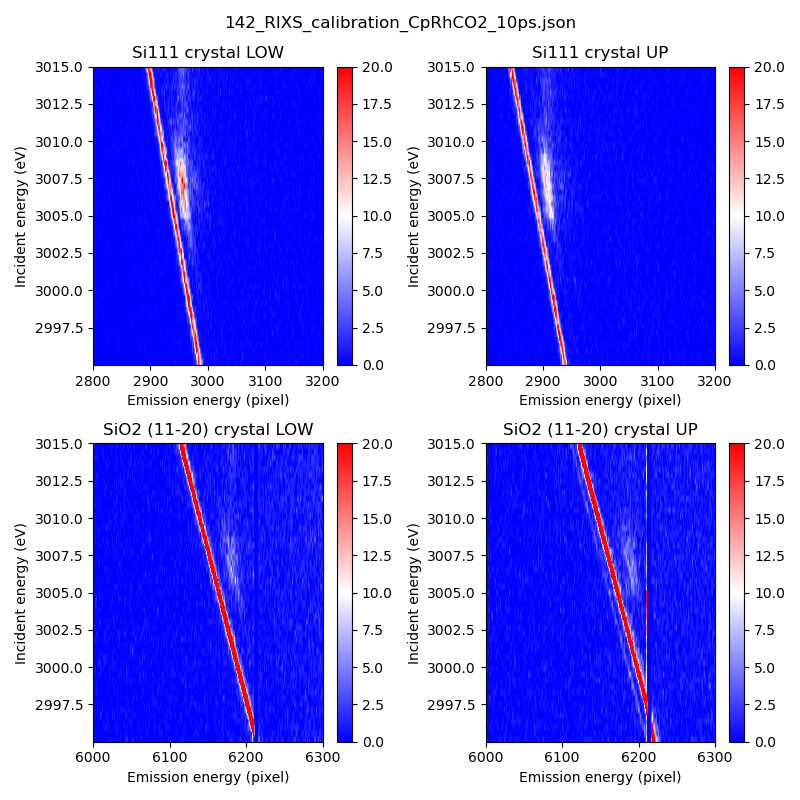

In [34]:
plt.figure(figsize=(8,8))
plt.suptitle(fc.selected_filename, fontsize=12)

plt.subplot(221)
plt.title('Si111 crystal LOW')
plt.imshow(RIXS_roi1, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi1[0], roi1[1], Energy_eV[0], Energy_eV[-1]], vmin=0, vmax=20)
plt.xlabel("Emission energy (pixel)")
plt.ylabel("Incident energy (eV)")
plt.colorbar()

plt.subplot(222)
plt.title('Si111 crystal UP')
plt.imshow(RIXS_roi2, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi2[0], roi2[1], Energy_eV[0],Energy_eV[-1]], vmin=0, vmax=20)
plt.xlabel("Emission energy (pixel)")
plt.ylabel("Incident energy (eV)")
plt.colorbar()

plt.subplot(223)
plt.title('SiO2 (11-20) crystal LOW')
plt.imshow(RIXS_roi3, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi3[0], roi3[1], Energy_eV[0],Energy_eV[-1]], vmin=0, vmax=20)
plt.xlabel("Emission energy (pixel)")
plt.ylabel("Incident energy (eV)")
plt.colorbar()

plt.subplot(224)
plt.title('SiO2 (11-20) crystal UP')
plt.imshow(RIXS_roi4, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi4[0], roi4[1], Energy_eV[0],Energy_eV[-1]], vmin=0, vmax=20)
plt.xlabel("Emission energy (pixel)")
plt.ylabel("Incident energy (eV)")
plt.colorbar()

plt.tight_layout()
plt.show()

#plt.savefig(savedir+'/RIXS_plane_single_2')

In [35]:
np.shape(Energy_eV)

(51,)

<IPython.core.display.Javascript object>


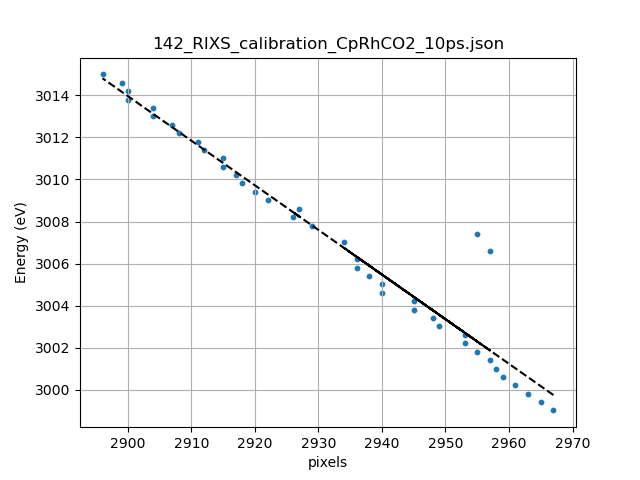

m = -0.21231665822713133 eV/pixel
b = 3629.6848888430545 eV


In [36]:
energyrange = np.arange(np.shape(RIXS_roi1)[0])
lowlimit = 10
highlimit = 51
maxpos = []
for index in energyrange:
    maxpos.append(np.argmax(np.array(RIXS_roi1)[index,:])+roi1[0])
maxpos = np.asarray(maxpos)

m,b = np.polyfit(maxpos[lowlimit:highlimit], Energy_eV[lowlimit:highlimit], 1) 

plt.figure()
plt.title(fc.selected_filename)
plt.scatter(maxpos[lowlimit:highlimit],Energy_eV[lowlimit:highlimit], s = 10)
plt.plot(maxpos[lowlimit:highlimit], m*(maxpos[lowlimit:highlimit]) + b,  '--', color='black')
plt.grid()
plt.xlabel('pixels')
plt.ylabel('Energy (eV)')
plt.show()

print ('m = {} eV/pixel'.format(m))
print ('b = {} eV'.format (b))

<IPython.core.display.Javascript object>


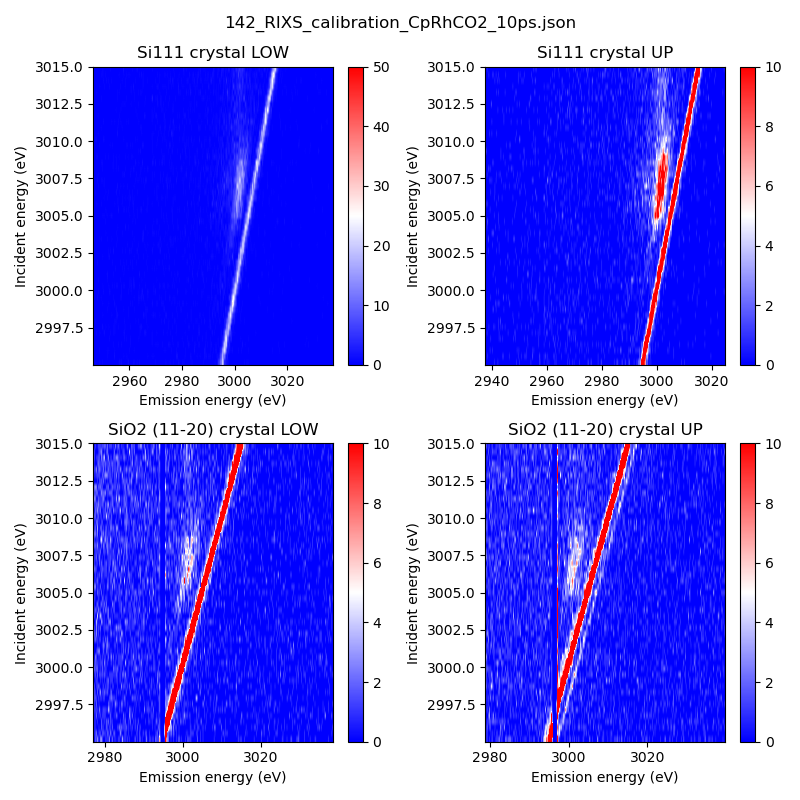

In [52]:
m1 = -0.227823729813514
b1 = 3675.197589071378

m2 = -0.2178046551195024 
b2 = 3634.5932774232842

m3 = -0.20497418938886694
b3 = 4268.395494620989

m4 = -0.20258904884840512
b4 = 4255.182572295174

xaxis1 = np.linspace(roi1[0]*m1+b1, roi1[1]*m1+b1, roi1[1]-roi1[0])
xaxis2 = np.linspace(roi2[0]*m2+b2, roi2[1]*m2+b2, roi2[1]-roi2[0])
xaxis3 = np.linspace(roi3[0]*m3+b3, roi3[1]*m3+b3, roi3[1]-roi3[0])
xaxis4 = np.linspace(roi4[0]*m4+b4, roi4[1]*m4+b4, roi4[1]-roi4[0])


plt.figure(figsize=(8,8))
plt.suptitle(fc.selected_filename, fontsize=12)

plt.subplot(221)
plt.title('Si111 crystal LOW')
plt.imshow(RIXS_roi1, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[xaxis1[0], xaxis1[-1], Energy_eV[0], Energy_eV[-1]], vmin=0, vmax=50)
plt.gca().invert_xaxis()
plt.xlabel("Emission energy (eV)")
plt.ylabel("Incident energy (eV)")
plt.colorbar()

plt.subplot(222)
plt.title('Si111 crystal UP')
plt.imshow(RIXS_roi2, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[xaxis2[0], xaxis2[-1], Energy_eV[0],Energy_eV[-1]], vmin=0, vmax=10)
plt.gca().invert_xaxis()
plt.xlabel("Emission energy (eV)")
plt.ylabel("Incident energy (eV)")
plt.colorbar()

plt.subplot(223)
plt.title('SiO2 (11-20) crystal LOW')
plt.imshow(RIXS_roi3, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[xaxis3[0], xaxis3[-1], Energy_eV[0],Energy_eV[-1]], vmin=0, vmax=10)
plt.gca().invert_xaxis()
plt.xlabel("Emission energy (eV)")
plt.ylabel("Incident energy (eV)")
plt.colorbar()

plt.subplot(224)
plt.title('SiO2 (11-20) crystal UP')
plt.imshow(RIXS_roi4, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[xaxis4[0], xaxis4[-1], Energy_eV[0],Energy_eV[-1]], vmin=0, vmax=10)
plt.gca().invert_xaxis()
plt.xlabel("Emission energy (eV)")
plt.ylabel("Incident energy (eV)")
plt.colorbar()

plt.tight_layout()
plt.show()

#plt.savefig(savedir+'/RIXS_plane_Si111_lower_Rhacac.png')

In [44]:
def interpstuff(RIXS_2D, xaxis, energy):
    indexinter = np.arange(np.shape(RIXS_2D)[0])
    interp_axis = np.arange((xaxis - energy[-1])[-1], (xaxis - energy[0])[0], xaxis[0]-xaxis[1])

    RIXS_roi1_interp = []

    for index in indexinter:
        RIXS_roi1_interp.append(np.interp(interp_axis, -(xaxis - energy[index]), np.array(RIXS_2D)[index,:]))
        
    return (interp_axis, RIXS_roi1_interp)

In [53]:
indexinter = np.arange(np.shape(RIXS_roi1)[0])
interp_axis1 = np.arange((xaxis1 - Energy_eV[-1])[-1], (xaxis1 - Energy_eV[0])[0], xaxis1[0]-xaxis1[1])

RIXS_roi1_interp = []

for index in indexinter:
    RIXS_roi1_interp.append(np.interp(interp_axis, -(xaxis1 - Energy_eV[index]), np.array(RIXS_roi1)[index,:]))

In [54]:
interp_axis1, RIXS_map_interp1 = interpstuff(RIXS_roi1, xaxis1, Energy_eV)
interp_axis2, RIXS_map_interp2 = interpstuff(RIXS_roi2, xaxis2, Energy_eV)
interp_axis3, RIXS_map_interp3 = interpstuff(RIXS_roi3, xaxis3, Energy_eV)
interp_axis4, RIXS_map_interp4 = interpstuff(RIXS_roi4, xaxis4, Energy_eV)

<IPython.core.display.Javascript object>


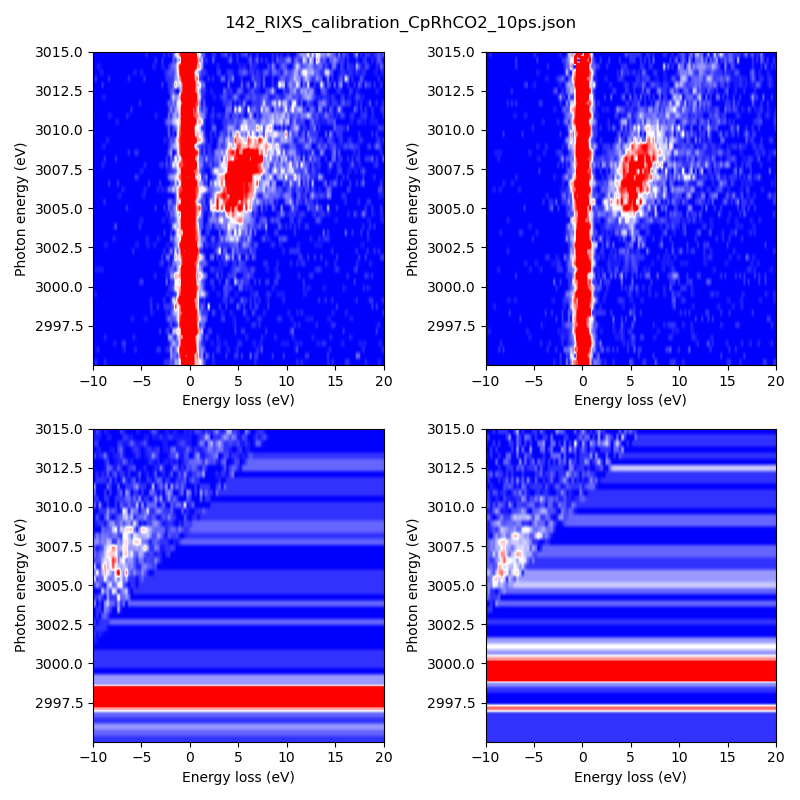

In [55]:
plt.figure(figsize=(8,8))
plt.suptitle(fc.selected_filename, fontsize=12)

plt.subplot(221)
plt.imshow(RIXS_roi1_interp, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[interp_axis1[0], interp_axis1[-1], Energy_eV[0], Energy_eV[-1]], vmin=0, vmax=10)
plt.xlim(-10,20)
plt.xlabel('Energy loss (eV)')
plt.ylabel('Photon energy (eV)')
plt.show()

plt.subplot(222)
plt.imshow(RIXS_roi2_interp, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[interp_axis2[0], interp_axis2[-1], Energy_eV[0], Energy_eV[-1]], vmin=0, vmax=10)
plt.xlim(-10,20)
plt.xlabel('Energy loss (eV)')
plt.ylabel('Photon energy (eV)')
plt.show()

plt.subplot(223)
plt.imshow(RIXS_roi3_interp, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[interp_axis3[0], interp_axis3[-1], Energy_eV[0], Energy_eV[-1]], vmin=0, vmax=10)
plt.xlim(-10,20)
plt.xlabel('Energy loss (eV)')
plt.ylabel('Photon energy (eV)')
plt.show()

plt.subplot(224)
plt.imshow(RIXS_roi4_interp, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[interp_axis4[0], interp_axis4[-1], Energy_eV[0], Energy_eV[-1]], vmin=0, vmax=10)
plt.xlim(-10,20)
plt.xlabel('Energy loss (eV)')
plt.ylabel('Photon energy (eV)')
plt.show()

plt.tight_layout()
#plt.savefig(savedir+'/RIXS_Eloss_Si111_lower_Rhacac.png')

In [716]:
indexlist = np.arange(65,100,1)
Energy_eV[indexlist]

array([3022.50562809, 3023.00466412, 3023.50410547, 3024.00398235,
       3024.50351926, 3025.00396952, 3025.50452772, 3026.00483524,
       3026.50495134, 3027.00430731, 3027.50436819, 3028.00537426,
       3028.50484071, 3029.00282522, 3029.50259317, 3030.00378693,
       3030.50301768, 3031.00502553, 3031.50524917, 3032.00434702,
       3032.5056239 , 3033.00415063, 3033.50524863, 3034.00260018,
       3034.50252391, 3035.00571605, 3035.50473607, 3036.00295544,
       3036.50447576, 3037.00483444, 3037.50230861, 3038.00589641,
       3038.50554188, 3039.00347699, 3039.50447868])

<IPython.core.display.Javascript object>


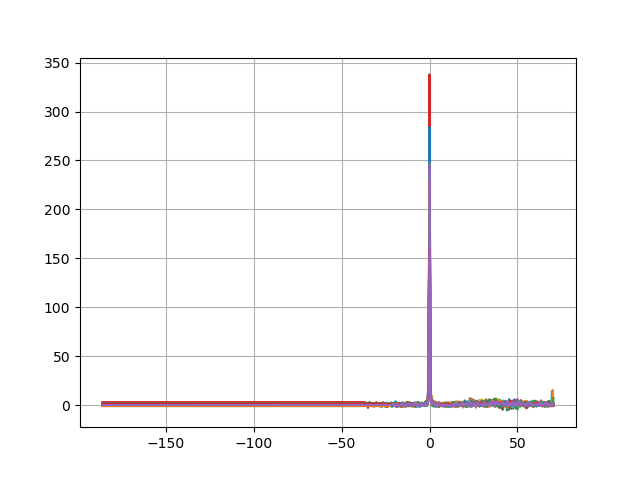

In [717]:
common_axis = np.arange((xaxis3 - Energy_eV[100])[-1], (xaxis3 - Energy_eV[0])[0], xaxis3[0]-xaxis3[1])

total_roi3 = 0
plt.figure()
for index in indexlist:
    #plt.plot(xaxis3 - Energy_eV[0],np.array(RIXS_roi3)[0,:], label = 'E={}'.format(np.round(Energy_eV[0],1)))
    total_roi3 +=  np.interp(common_axis, -(xaxis3 - Energy_eV[index]), np.array(RIXS_roi3)[index,:])
    plt.plot(common_axis, np.interp(common_axis, -(xaxis3 - Energy_eV[index]), np.array(RIXS_roi3)[index,:]))
plt.grid()
plt.show()

/sf/alvra/anaconda/alvra-analysis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


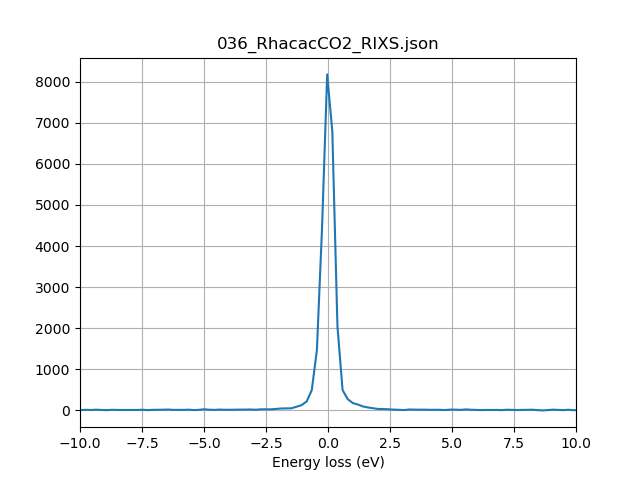

In [719]:
plt.figure()
plt.title(fc.selected_filename)
plt.plot(common_axis, total_roi3)

plt.grid()

plt.xlim(-10,10)
#plt.ylim(0,700)
plt.xlabel('Energy loss (eV)')

plt.show()

plt.savefig(savedir+'/elastic_Si111_lower_Rhacac.png')

In [496]:
indexlist = np.arange(45,56,1)
indexlist

/sf/alvra/anaconda/alvra-analysis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55])

/sf/alvra/anaconda/alvra-analysis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


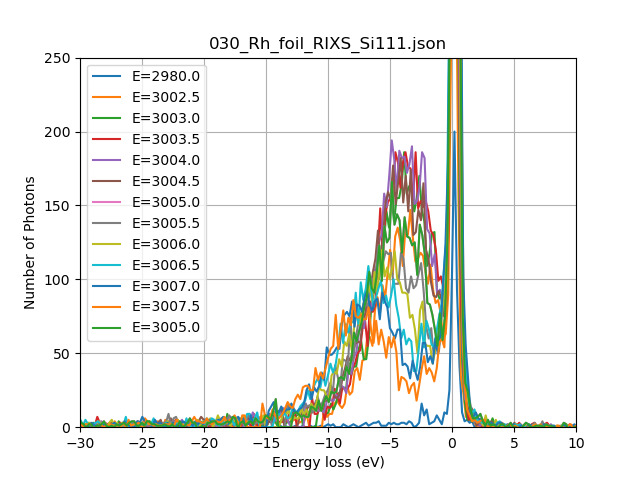

In [499]:
plt.figure()
plt.title(fc.selected_filename)
plt.plot(xaxis3 - Energy_eV[0], np.array(RIXS_roi3)[0,:], label = 'E={}'.format(np.round(Energy_eV[0],1)))
for index in indexlist:
    #offset += 20
    plt.plot(xaxis3 - Energy_eV[index], np.array(RIXS_roi3)[index,:], label = 'E={}'.format(np.round(Energy_eV[index],1)))

plt.plot(xaxis3 - Energy_eV[50], np.array(RIXS_roi3)[50,:], label = 'E={}'.format(np.round(Energy_eV[50],1)))
plt.xlim(-30,10)
plt.legend(loc='best')
plt.xlabel('Energy loss (eV)')
plt.ylabel('Number of Photons')
plt.ylim(0,250)
plt.grid()
plt.show()

plt.savefig(savedir+'/resonances_Si111.png')

In [250]:
from scipy.optimize import curve_fit

class Fit:
    
    def __init__(self, func, estim, p0=None):
        self.func = func
        self.estim = estim
        self.p0 = self.popt = p0
        self.pcov = None
   
    def estimate(self, x, y):
        self.p0 = self.popt = self.estim(x,y)

    def fit(self, x, y):
        self.popt, self.pcov = curve_fit(self.func, x, y, p0=self.p0)
    
    def eval(self, x):
        return self.func(x, *self.popt)

In [262]:
fit.popt

/sf/alvra/anaconda/alvra-analysis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([-0.79537398, 20.4592576 ,  2.54319107,  0.67786012])

/sf/alvra/anaconda/alvra-analysis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


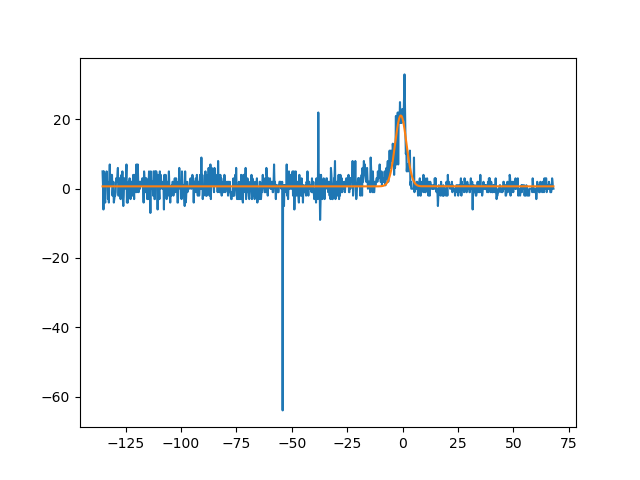

width = 6.485088970572784


In [268]:


fit = Fit(gaussian, estimate_gaussian_parameters)
fit.estimate(xaxis3 - Energy_eV[0], np.array(RIXS_roi3)[0,:])
fit.p0 = better_p0(fit.p0, 0, 0)

fit.fit(xaxis3 - Energy_eV[0],np.array(RIXS_roi3)[0,:])


plt.figure()
plt.plot(xaxis3 - Energy_eV[0], np.array(RIXS_roi3)[0,:], label = 'E={}'.format(np.round(Energy_eV[0],1)))
plt.plot(xaxis3 - Energy_eV[0], fit.eval(xaxis3 - Energy_eV[0]), label = 'E={}'.format(np.round(Energy_eV[0],1)))

plt.show()
print('width = {}'.format(np.abs(fit.popt[2]*2.55)))

In [89]:
datalist = []
for file in glob('/sf/alvra/data/p19262/raw/scan_data/027_Rh_foil*'):
    datalist.append(file)
datalist = sorted(datalist)#, key = os.path.getmtime)
patch = datalist[:-1]
patch

/sf/alvra/anaconda/alvra-analysis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['/sf/alvra/data/p19262/raw/scan_data/027_Rh_foil_RIXS_001',
 '/sf/alvra/data/p19262/raw/scan_data/027_Rh_foil_RIXS_002',
 '/sf/alvra/data/p19262/raw/scan_data/027_Rh_foil_RIXS_003',
 '/sf/alvra/data/p19262/raw/scan_data/027_Rh_foil_RIXS_004',
 '/sf/alvra/data/p19262/raw/scan_data/027_Rh_foil_RIXS_005',
 '/sf/alvra/data/p19262/raw/scan_data/027_Rh_foil_RIXS_006',
 '/sf/alvra/data/p19262/raw/scan_data/027_Rh_foil_RIXS_007',
 '/sf/alvra/data/p19262/raw/scan_data/027_Rh_foil_RIXS_008',
 '/sf/alvra/data/p19262/raw/scan_data/027_Rh_foil_RIXS_009',
 '/sf/alvra/data/p19262/raw/scan_data/027_Rh_foil_RIXS_010',
 '/sf/alvra/data/p19262/raw/scan_data/027_Rh_foil_RIXS_011']

In [94]:
roi1 = (2600, 3600, 200, 260) #signal 1
roi2 = (2600, 3600, 100, 160) #bkg 1

roi3 = (5900, 6900, 200, 260) #signal 2
roi4 = (5900, 6900, 100, 160) #bkg 2

threshold_low = 2.0
threshold_high = 10

channel_list = ['JF02T09V02']

######################################################################################
from sfdata import SFScanInfo

RIXS_roi1_all = []
XAS_roi1_all = []
RIXS_roi3_all = []
XAS_roi3_all = []

for json_file in patch:

    scan = SFScanInfo(fc.selected)
    Energy_eV = scan.readbacks

    XAS_roi1 = []
    XAS_roi3 = []
    calibration = []
    RIXS_roi1 = []
    RIXS_roi3 = []

    for i, step in enumerate(scan.files):

        fn = step[3]
        print (json_file.split('/')[-1])
        print ("File {} out of {}: Processing {}".format(i+1, len(scan.files), fn.split('/')[-1]))

        spectrum_roi1 = 0
        spectrum_roi2 = 0
        spectrum_roi3 = 0
        spectrum_roi4 = 0

        nshots = None

        images_roi1, images_roi2, images_roi3, images_roi4, pids = \
        load_crop_JF_batches(fn, roi1, roi2, roi3, roi4, nshots=nshots)

        images_roi1_thr = images_roi1.copy()
        images_roi1_thr[images_roi1 < threshold_low] = 0
        images_roi1_thr[images_roi1 > threshold_high] = 0

        images_roi2_thr = images_roi2.copy()
        images_roi2_thr[images_roi2 < threshold_low] = 0
        images_roi2_thr[images_roi2 > threshold_high] = 0

        images_roi3_thr = images_roi3.copy()
        images_roi3_thr[images_roi3 < threshold_low] = 0
        images_roi3_thr[images_roi3 > threshold_high] = 0

        images_roi4_thr = images_roi4.copy()
        images_roi4_thr[images_roi4 < threshold_low] = 0
        images_roi4_thr[images_roi4 > threshold_high] = 0


        spectrum_roi1  = images_roi1_thr.sum(axis = 1).sum(axis = 0)
        spectrum_roi2  = images_roi2_thr.sum(axis = 1).sum(axis = 0)
        spectrum_roi3  = images_roi3_thr.sum(axis = 1).sum(axis = 0)
        spectrum_roi4  = images_roi4_thr.sum(axis = 1).sum(axis = 0)

        XAS_roi1.append(np.abs((spectrum_roi1 - spectrum_roi2).sum()))
        XAS_roi3.append(np.abs((spectrum_roi3 - spectrum_roi4).sum()))
        #print (np.argmax(spectrum_roi3 - spectrum_roi4))
        calibration.append(np.argmax(spectrum_roi1 - spectrum_roi2))

        RIXS_roi1.append(spectrum_roi1 - spectrum_roi2)
        RIXS_roi3.append(spectrum_roi3 - spectrum_roi4)
        clear_output(wait=True)
        print ("It took", clock.tick(), "seconds to process this file")

    RIXS_roi1_all.append(RIXS_roi1)
    XAS_roi1_all.append(XAS_roi1)
    
    RIXS_roi3_all.append(RIXS_roi3)
    XAS_roi3_all.append(XAS_roi3)
    
    print ("\nJob done! It took", clock.tock(), "seconds to process", len(scan.files), "file(s)")

RIXS_roi1_all = np.asarray(RIXS_roi1_all)
XAS_roi1_all = np.asarray(XAS_roi1_all)
RIXS_roi3_all = np.asarray(RIXS_roi3_all)
XAS_roi3_all = np.asarray(XAS_roi3_all)



It took 7.5 seconds to process this file

Job done! It took 21877.1 seconds to process 101 file(s)


/sf/alvra/anaconda/alvra-analysis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


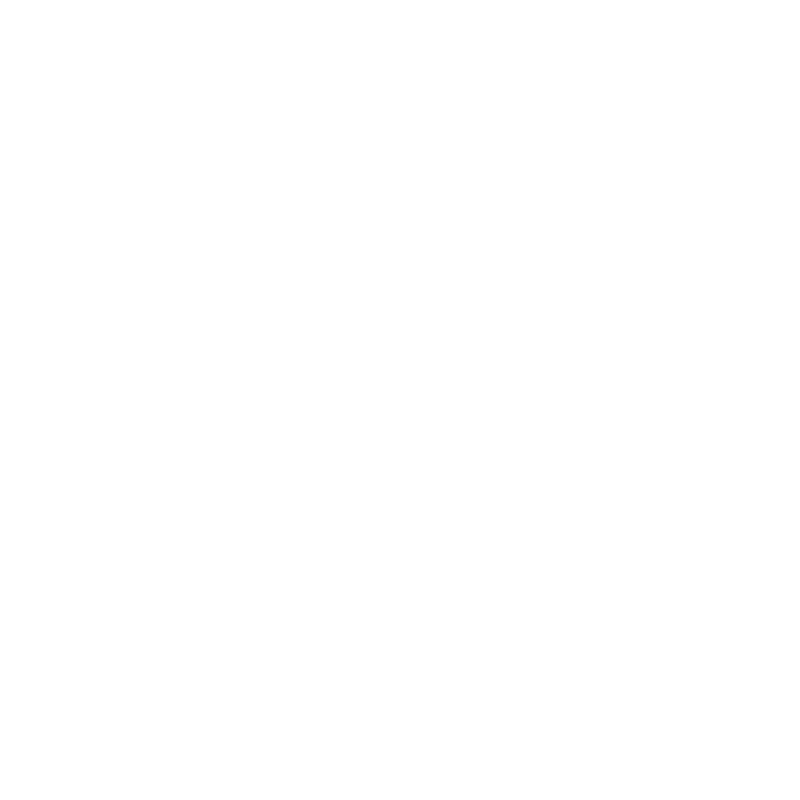

NameError: name 'json_file' is not defined

In [339]:
m1 = -0.21348314606741572
b1 = 3001.3 - 2957.4*m1

m3 = -(1/4.913043478260869) 
b3 = 3001.3 - 6179*m3  

#m=1
#b=0
xaxis1 = np.linspace(roi1[0]*m1+b1, roi1[1]*m1+b1, roi1[1]-roi1[0])
xaxis3 = np.linspace(roi3[0]*m3+b3, roi3[1]*m3+b3, roi3[1]-roi3[0])


plt.figure(figsize=(8,8))
plt.suptitle('11 RIXS from {}'.format(json_file.split('/')[-1]), fontsize=12)

plt.subplot(211)
plt.title('Si111 crystals')
plt.imshow(RIXS_roi1_all_photons, label="Ka", aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[xaxis1[0], xaxis1[-1], Energy_eV[0], Energy_eV[-1]], vmin=0, vmax=100)
plt.gca().invert_xaxis()
plt.xlabel("Emission energy (pixel)")
plt.ylabel("Incident energy (eV)")
plt.colorbar()
plt.legend(loc="best")

plt.subplot(212)
plt.title('SiO2 (11-20) crystals')
plt.imshow(RIXS_roi3_all_photons, aspect = 'auto', cmap = "bwr", label="Kb", origin ="lower", \
           extent=[xaxis3[0], xaxis3[-1], Energy_eV[0],Energy_eV[-1]], vmin=0, vmax=100)
plt.gca().invert_xaxis()
plt.xlabel("Emission energy (eV)")
plt.ylabel("Incident energy (eV)")
plt.legend(loc="best")
plt.colorbar()

plt.tight_layout()
plt.show()

plt.savefig(savedir+'/RIXS_plane_avg_2')

In [165]:
1/((2876 - 2787) / 19)

0.21348314606741572

/sf/alvra/anaconda/alvra-analysis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


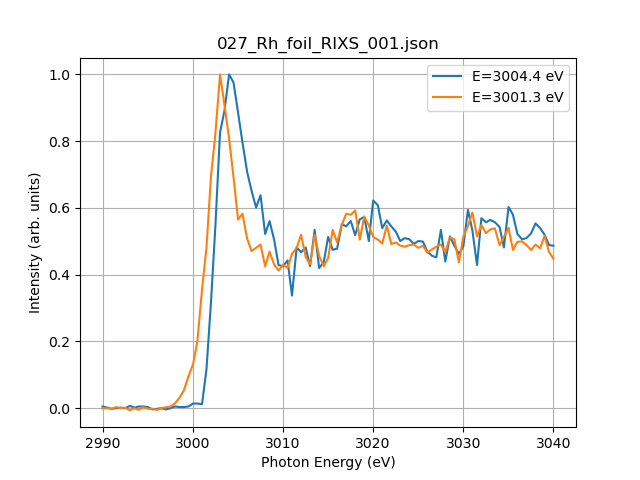

In [47]:
plt.figure()
plt.title(fc.selected_filename)
plt.plot(Energy_eV,np.mean(np.array(RIXS_roi3)[:,263:265],axis=1)/np.max(np.mean(np.array(RIXS_roi3)[:,263:265],axis=1)), label ='E=3004.4 eV' )
plt.plot(Energy_eV,np.array(RIXS_roi3)[:,279]/np.max(np.array(RIXS_roi3)[:,279]), label ='E=3001.3 eV')
plt.legend(loc='best')
plt.xlabel('Photon Energy (eV)')
plt.ylabel('Intensity (arb. units)')

plt.grid()
plt.show()

plt.savefig(savedir+'/Lb215_vs_Vtc')

/sf/alvra/anaconda/alvra-analysis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


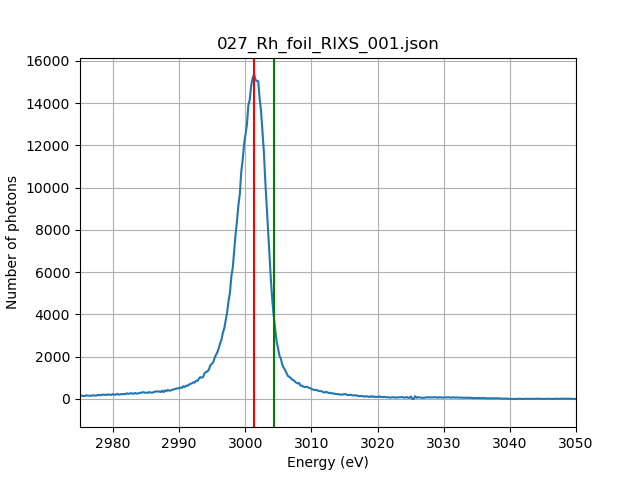

In [338]:
plt.figure()
plt.title(fc.selected_filename)
plt.plot(xaxis1, np.sum(np.array(RIXS_roi1)[-20:,:], axis =0))
plt.grid()
plt.xlim(2975, 3050)
plt.axvline(3001.3, color = 'r')
plt.axvline(3004.4, color = 'g')
plt.ylabel('Number of photons')
plt.xlabel('Energy (eV)')

plt.show()
#plt.savefig(savedir+'/Lb_VtC_integrated_Si111')

/sf/alvra/anaconda/alvra-analysis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


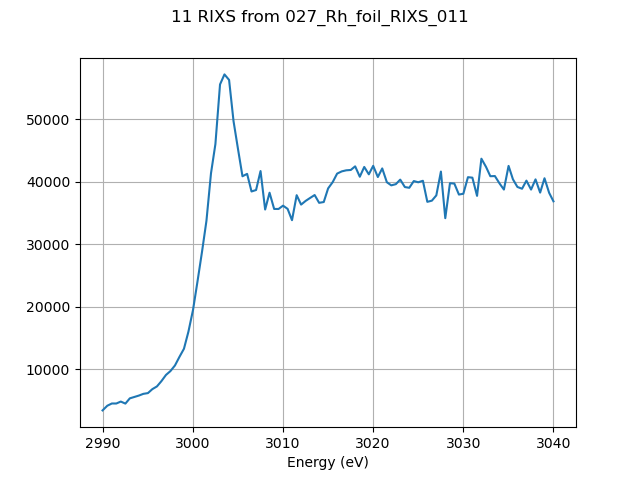

In [296]:
plt.figure()
plt.suptitle('11 RIXS from {}'.format(json_file.split('/')[-1]), fontsize=12)
plt.plot(Energy_eV, np.mean(XAS_roi3_all, axis=0))
plt.grid()
plt.xlabel('Energy (eV)')
plt.show()
plt.savefig(savedir+'/XANES_VonHamos.png')

## Next cells for an energy, any channel (BSDATA & JF) 

In [12]:
fc = FileChooser('/sf/alvra/data/p18442/res/scan_info')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p18442/res/scan_info', filename='', show_hidden='False')

In [13]:
channel_list = [channel_PIPS_fluo, 'JF02T09V02']

roi1 = (5000, 5150, 220, 290) # Ru La ROIs
roi2 = (5000, 5150, 290, 360) 

roi3 = (2000, 2200, 10, 210)   # Lb _not set correctly!
roi4 = (2000, 2200, 230, 430)   # Kb_background


threshold_low = 2

####################################################################################################3
clock = Clock()
from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)
Energy_eV = scan.readbacks

XAS_roi1 = []
XAS_roi3 = []
calibration = []
RIXS_roi1 = []
RIXS_roi3 = []

for i, step in enumerate(scan):
    check_files_and_data(step)
    clear_output(wait=True)
    filename = scan.files[i][0].split('/')[-1].split('.')[0]
    print ('Step {} of {}: Processing {}'.format(i+1, len(scan.files), filename))
    
    spectrum_roi1 = 0
    spectrum_roi2 = 0
    spectrum_roi3 = 0
    spectrum_roi4 = 0
    
    results = load_data_compact(channel_list, step)
    
    Data_fluo = results[channel_PIPS_fluo]
    images = results['JF02T09V02']
    
    images_roi1 = crop_roi(images, roi1)
    images_roi2 = crop_roi(images, roi2)
    images_roi3 = crop_roi(images, roi3)
    images_roi4 = crop_roi(images, roi4)
    
    images_roi1_thr = images_roi1.copy()
    images_roi1_thr[images_roi1 < threshold_low] = 0
    #images_roi1_thr[images_roi1 > threshold_high] = 0
    
    images_roi2_thr = images_roi2.copy()
    images_roi2_thr[images_roi2 < threshold_low] = 0
    #images_roi2_thr[images_roi2 > threshold_high] = 0
    
    images_roi3_thr = images_roi3.copy()
    images_roi3_thr[images_roi3 < threshold_low] = 0
    #images_roi3_thr[images_roi3 > threshold_high] = 0
    
    images_roi4_thr = images_roi4.copy()
    images_roi4_thr[images_roi4 < threshold_low] = 0
    #images_roi4_thr[images_roi4 > threshold_high] = 0
    
    spectrum_roi1  = images_roi1_thr.sum(axis = 1).sum(axis = 0)
    spectrum_roi2  = images_roi2_thr.sum(axis = 1).sum(axis = 0)
    spectrum_roi3  = images_roi3_thr.sum(axis = 1).sum(axis = 0)
    spectrum_roi4  = images_roi4_thr.sum(axis = 1).sum(axis = 0)
    
    XAS_roi1.append(np.abs((spectrum_roi1 - spectrum_roi2).sum()))
    XAS_roi3.append(np.abs((spectrum_roi3 - spectrum_roi4).sum()))
    #print (np.argmax(spectrum_roi3 - spectrum_roi4))
    calibration.append(np.argmax(spectrum_roi1 - spectrum_roi2))

    RIXS_roi1.append(spectrum_roi1 - spectrum_roi2)
    RIXS_roi3.append(spectrum_roi3 - spectrum_roi4)
    
    print ("It took", clock.tick(), "seconds to process this file")
    
XAS_roi1 = np.array(XAS_roi1)
XAS_roi3 = np.array(XAS_roi3)

calibration = np.array(calibration)
RIXS_roi1 = np.array(RIXS_roi1)
RIXS_roi3 = np.array(RIXS_roi3)

print ("\nJob done! It took", clock.tock(), "seconds to process all the files")

Step 41 of 41: Processing run_000952

--------------------------------------------------------------------------------

JF02T09V02               2500 / 4999 -> 50% loss ▇▇▇▇▇
SAR-CVME-TIFALL5:EvtSet  4999 / 4999 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH2_VAL_GET 4999 / 4999 ->  0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 2500 / 4999 -> 50% loss
complete channels: 2 / 3 -> 33% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
It took 55.7 seconds to process this file

Job done! It took 2280.56 seconds to process all the files


<IPython.core.display.Javascript object>


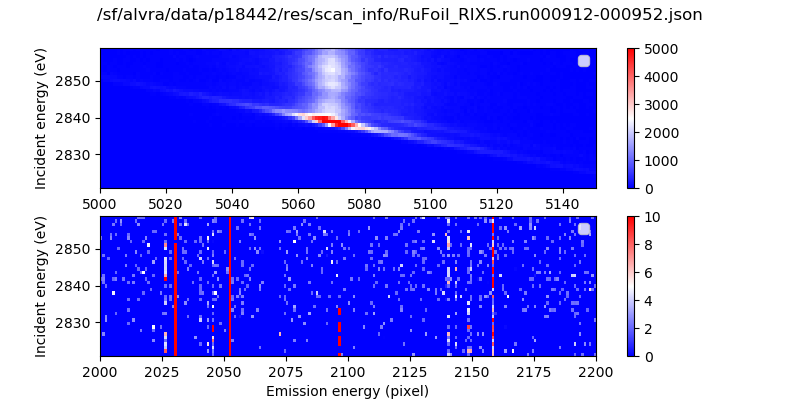

No handles with labels found to put in legend.
No handles with labels found to put in legend.


In [14]:
plt.figure(figsize=(8,4))
plt.suptitle(fc.selected, fontsize=12)
plt.subplot(211)
plt.imshow(RIXS_roi1, label="Ka", aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi1[0], roi1[1], Energy_eV[0], Energy_eV[-1]], vmin=0, vmax=5000)
plt.xlabel("Emission energy (pixel)")
plt.ylabel("Incident energy (eV)")
plt.colorbar()
plt.legend(loc="best")

plt.subplot(212)
plt.imshow(RIXS_roi3, aspect = 'auto', cmap = "bwr", label="Kb", origin ="lower", \
           extent=[roi3[0], roi3[1], Energy_eV[0], Energy_eV[-1]], vmin=0, vmax=10)
plt.xlabel("Emission energy (pixel)")
plt.ylabel("Incident energy (eV)")
plt.legend(loc="best")
plt.colorbar()
plt.show()


<IPython.core.display.Javascript object>


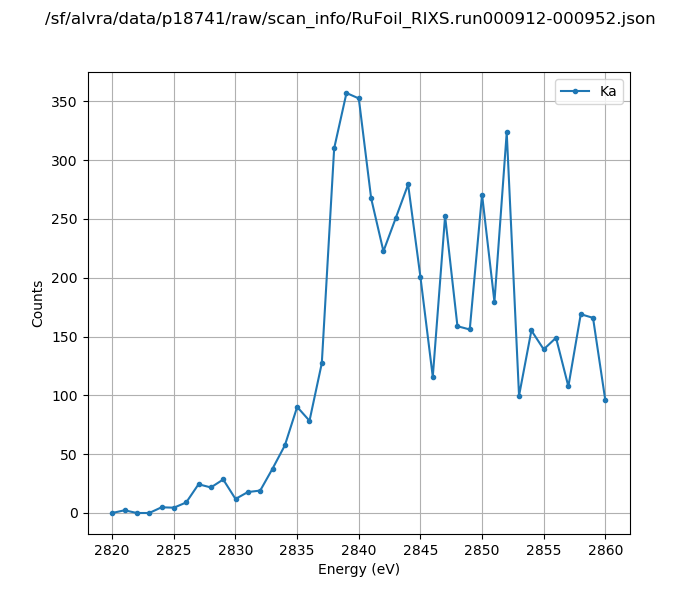

In [29]:
plt.figure(figsize=(7,6))
plt.suptitle(json_file, fontsize=12)

plt.plot(Energy_eV, XAS_roi1,label="Ka", marker='.')
plt.xlabel("Energy (eV)")
plt.ylabel("Counts")
plt.legend(loc="best")
plt.grid()

plt.show()

## Next cells for a single file, any channel (BSDATA & JF) 

In [ ]:
fc = FileChooser('/sf/alvra/data/p19262/raw/scan_info')
fc.use_dir_icons = True
display(fc)

In [ ]:
data = SFDataFiles('/sf/alvra/data/p18938/raw/XES_jet/run_008899*')

channel_list = [channel_PIPS_fluo, channel_Izero117, 'JF02T09V02']

roi1 = (7740, 7880, 290, 340) #signal 1
roi2 = (7740, 7880, 385, 435) #bkg 1

roi3 = (5080, 5220, 210, 250) #signal 2
roi4 = (5080, 5220, 145, 185) #bkg 2

threshold_low = 5

##########################################################
clock = Clock()
spectrum_roi1 = 0
spectrum_roi2 = 0
spectrum_roi3 = 0
spectrum_roi4 = 0
print (data.fnames[0])

results = load_data_compact_JF(channel_list, data, roi1, roi2, roi3, roi4)

data.close()

Data_fluo = results[channel_PIPS_fluo]
images_roi1 = results['JFroi1']
images_roi2 = results['JFroi2']
images_roi3 = results['JFroi3']
images_roi4 = results['JFroi4']

images_roi1_thr = images_roi1.copy()
images_roi1_thr[images_roi1 < threshold_low] = 0
#images_roi1_thr[images_roi1 > threshold_high] = 0

images_roi2_thr = images_roi2.copy()
images_roi2_thr[images_roi2 < threshold_low] = 0
#images_roi2_thr[images_roi2 > threshold_high] = 0

images_roi3_thr = images_roi3.copy()
images_roi3_thr[images_roi3 < threshold_low] = 0
#images_roi3_thr[images_roi3 > threshold_high] = 0

images_roi4_thr = images_roi4.copy()
images_roi4_thr[images_roi4 < threshold_low] = 0
#images_roi4_thr[images_roi4 > threshold_high] = 0

spectrum_roi1 = images_roi1_thr.sum(axis = 1).sum(axis = 0)
spectrum_roi2 = images_roi2_thr.sum(axis = 1).sum(axis = 0)
spectrum_roi3 = images_roi3_thr.sum(axis = 1).sum(axis = 0)
spectrum_roi4 = images_roi4_thr.sum(axis = 1).sum(axis = 0)

print ("It took", clock.tick(), "seconds to process this file")

In [ ]:
spectrum_bkg_roi1 = spectrum_roi1  - spectrum_roi2
err_spectrum_ro1 = np.sqrt(spectrum_roi1)
err_bkg_2 = np.sqrt(spectrum_roi2)

spectrum_bkg_roi3 = spectrum_roi3 - spectrum_roi4
err_spectrum_roi3 = np.sqrt(spectrum_roi3)
err_bkg_4 = np.sqrt(spectrum_roi4)


bin1_ = 1   # change the bin size if wanted, 1 is every pixel
bin3_ = 1

spectrum_bkg_1 = spectrum_bkg_roi1.copy()
spectrum_bkg_3 = spectrum_bkg_roi3.copy()
x_axis_1 = np.arange(roi1[0], roi1[1])
x_axis_3 = np.arange(roi3[0], roi3[1])


spectrum_rebin1  = bin_sum(spectrum_bkg_1,  bin1_)
x_axis_rebin1 = bin_mean(x_axis_1, bin1_)
spectrum_rebin3  = bin_sum(spectrum_bkg_3,  bin3_)
x_axis_rebin3 = bin_mean(x_axis_3, bin3_)


#low_err_Ka= (spectrum_rebin1)-np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
#high_err_Kb= (spectra_on_rebin1 - spectra_off_rebin1)+np.sqrt(spectra_on_err1**2+spectra_off_err1**2)

#spectrumAllOutFoc=spectra_on_rebin1 + spectra_off_rebin1
plt.figure()
plt.subplot(211)
#plt.title(scan_name + ", delay = {} ps".format(str(np.round(Delay_ps_single,3))))
plt.plot(x_axis_rebin1, spectrum_rebin1, label="Ka", marker='.')
plt.legend(loc="best")
plt.grid()

plt.subplot(212)
#plt.title(scan_name + ", delay = {} ps".format(str(np.round(Delay_ps_single,3))))
plt.plot(x_axis_rebin3, spectrum_rebin3, label="Ka", marker='.')
plt.legend(loc="best")
plt.grid()

#plt.title(jf_file)
plt.xlabel("JF pixel")
plt.show()

In [ ]:
def edge_removal(module_edge, roi_removal, array):
    index_edge = module_edge - roi_removal[0]
    array_input = array.copy()
    print (array[index_edge-1:index_edge+3])
    array[index_edge] = array[index_edge-1]/2
    array[index_edge-1] = array[index_edge-1]/2

    array[index_edge+1] = array[index_edge+2]/2
    array[index_edge+2] = array[index_edge+2]/2 
    print (array[index_edge-1:index_edge+3])
    return array, array_input

In [ ]:
spectrum_ON_roi1, spectrum_ON_roi1_orig = edge_removal(6472, roi1, spectrum_ON_roi1) 
spectrum_OFF_roi1, spectrum_OFF_roi1_orig = edge_removal(6472, roi1, spectrum_OFF_roi1) 